In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

In [2]:
datasets = {}
model_names = ['Claude_3.5_Sonnet', 'GPT_3.5', 'GPT_4o']
file_paths = [
    '../Data/qna_dataset_Claude3.5Sonnet_final.csv',
    '../Data/qna_dataset_GPT3.5_final.csv', 
    '../Data/qna_dataset_GPT4o_final.csv'
]

In [3]:
for model_name, file_path in zip(model_names, file_paths):
    try:
        df = pd.read_csv(file_path)
        datasets[model_name] = df
        print(f"✓ {model_name}: {df.shape[0]} rows × {df.shape[1]} columns")
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")

✓ Claude_3.5_Sonnet: 400 rows × 16 columns
✓ GPT_3.5: 400 rows × 16 columns
✓ GPT_4o: 400 rows × 16 columns


#### Phase 2: Phase 2: Core Outcome Variables Analysis

##### 1. Overall hallucination rates by model

  Claude_3.5_Sonnet:  49/400 ( 12.2%)
  GPT_3.5        :  75/400 ( 18.8%)
  GPT_4o         :  47/400 ( 11.8%)


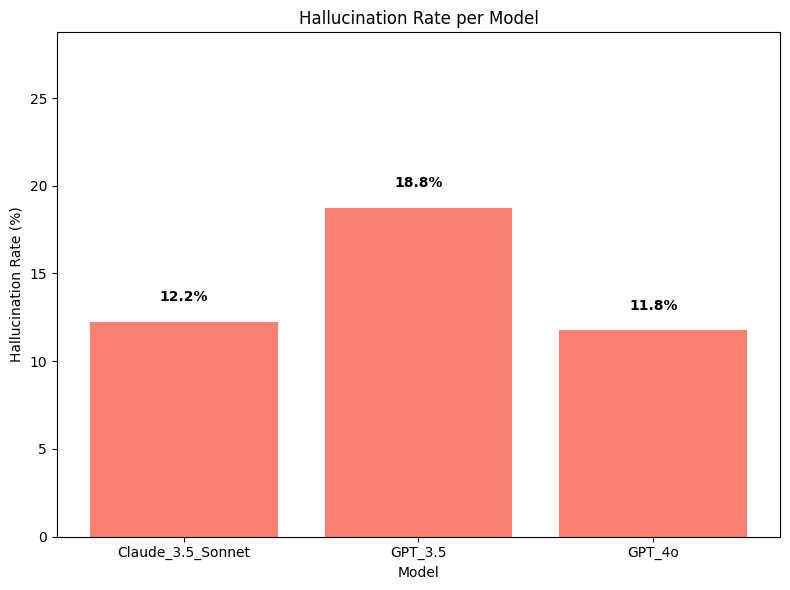

In [6]:
halluc_summary = {}
for model_name, df in datasets.items():
    # Convert hallucination_present to boolean if it's string
    if df['hallucination_present'].dtype == 'object':
        df['hallucination_present'] = df['hallucination_present'].map({
            'True': True, 'False': False, True: True, False: False
        })
    
    total_responses = len(df)
    hallucinated = df['hallucination_present'].sum()
    rate = (hallucinated / total_responses) * 100
    
    halluc_summary[model_name] = {
        'total': total_responses,
        'hallucinated': hallucinated,
        'rate_percent': rate
    }
    
    print(f"  {model_name:15}: {hallucinated:3d}/{total_responses} ({rate:5.1f}%)")

# -----------------------------
# 🎨 Visualization
# -----------------------------
model_names = list(halluc_summary.keys())
rates = [halluc_summary[m]['rate_percent'] for m in model_names]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, rates, color='salmon')
plt.title("Hallucination Rate per Model")
plt.ylabel("Hallucination Rate (%)")
plt.xlabel("Model")
plt.ylim(0, max(rates) + 10)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

##### 2. Domain-specific hallucination rates

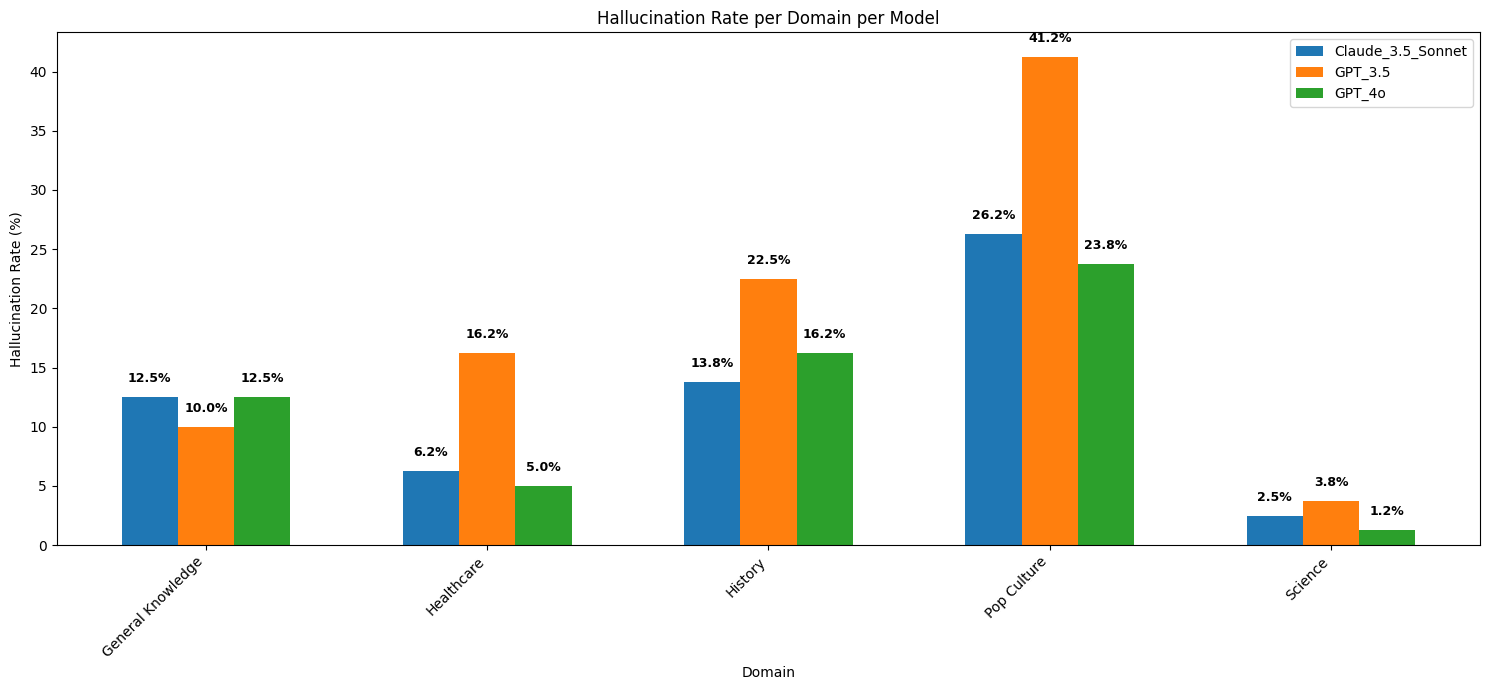

In [10]:
plt.figure(figsize=(15, 7))

for i, model in enumerate(model_names):
    bar_positions = x + i * bar_width
    rates = rate_matrix[i]
    
    bars = plt.bar(bar_positions, rates, width=bar_width, label=model)
    
    # Add value labels above each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2.0, height + 1,
                     f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labels and style
plt.xlabel('Domain')
plt.ylabel('Hallucination Rate (%)')
plt.title('Hallucination Rate per Domain per Model')
plt.xticks(x + bar_width, domains, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


##### Cross-tabulation: hallucination_present vs factscore

In [11]:
for model_name, df in datasets.items():
    print(f"\n  {model_name}:")
    crosstab = pd.crosstab(df['factscore'], df['hallucination_present'], 
                          margins=True, margins_name="Total")
    print(crosstab)
    
    # Check for logical consistency
    completely_right_halluc = df[(df['factscore'] == 'completely right') & 
                               (df['hallucination_present'] == True)]
    totally_wrong_factual = df[(df['factscore'] == 'totally wrong') & 
                             (df['hallucination_present'] == False)]
    
    if len(completely_right_halluc) > 0:
        print(f"    ⚠️  {len(completely_right_halluc)} 'completely right' responses marked as hallucinated")
    if len(totally_wrong_factual) > 0:
        print(f"    ⚠️  {len(totally_wrong_factual)} 'totally wrong' responses marked as factual")
    


  Claude_3.5_Sonnet:
hallucination_present  False  True  Total
factscore                                
completely right         224     0    224
somewhat correct         114     0    114
somewhat inaccurate       12    40     52
totally wrong              1     9     10
Total                    351    49    400
    ⚠️  1 'totally wrong' responses marked as factual

  GPT_3.5:
hallucination_present  False  True  Total
factscore                                
completely right         210     0    210
somewhat correct          87     0     87
somewhat inaccurate       28    59     87
totally wrong              0    16     16
Total                    325    75    400

  GPT_4o:
hallucination_present  False  True  Total
factscore                                
completely right         255     0    255
somewhat correct          79     0     79
somewhat inaccurate       18    37     55
totally wrong              1    10     11
Total                    353    47    400
    ⚠️  1 'totally 

In [12]:
print(f"\n🏆 Domain Rankings by Hallucination Rate:")
print("-" * 50)

# Calculate average hallucination rate per domain across all models
domain_avg_rates = {}
for domain in all_domains:
    rates = []
    for model_name in datasets.keys():
        if domain in domain_summary and model_name in domain_summary[domain]:
            rates.append(domain_summary[domain][model_name]['rate_percent'])
    
    if rates:
        domain_avg_rates[domain] = np.mean(rates)

# Sort domains by average hallucination rate
sorted_domains = sorted(domain_avg_rates.items(), key=lambda x: x[1], reverse=True)

print("  📈 Highest to Lowest Hallucination Rates (average across models):")
for i, (domain, avg_rate) in enumerate(sorted_domains, 1):
    print(f"    {i}. {domain:15}: {avg_rate:5.1f}%")


🏆 Domain Rankings by Hallucination Rate:
--------------------------------------------------
  📈 Highest to Lowest Hallucination Rates (average across models):
    1. Pop Culture    :  30.4%
    2. History        :  17.5%
    3. General Knowledge:  11.7%
    4. Healthcare     :   9.2%
    5. Science        :   2.5%


##### Overall FactScore distribution by model

In [13]:
 factscore_results = {}
    
# Define FactScore order for consistent analysis
factscore_order = ['completely right', 'somewhat correct', 'somewhat inaccurate', 'totally wrong']
factscore_numeric = {'completely right': 4, 'somewhat correct': 3, 
                    'somewhat inaccurate': 2, 'totally wrong': 1}

# 1. Overall FactScore distribution by model
print("📊 FactScore Distribution by Model:")
print("-" * 45)

model_factscore_summary = {}

for model_name, df in datasets.items():
    print(f"\n  🤖 {model_name}:")
    
    factscore_counts = df['factscore'].value_counts()
    factscore_pct = (factscore_counts / len(df)) * 100
    
    # Store results in order
    model_distribution = {}
    for score in factscore_order:
        count = factscore_counts.get(score, 0)
        pct = factscore_pct.get(score, 0)
        model_distribution[score] = {'count': count, 'percentage': pct}
        
        if score == 'completely right':
            emoji = "🟢"
        elif score == 'somewhat correct':
            emoji = "🟡"
        elif score == 'somewhat inaccurate':
            emoji = "🟠"
        else:  # totally wrong
            emoji = "🔴"
            
        print(f"    {emoji} {score:18}: {count:3d} ({pct:5.1f}%)")
    
    model_factscore_summary[model_name] = model_distribution

📊 FactScore Distribution by Model:
---------------------------------------------

  🤖 Claude_3.5_Sonnet:
    🟢 completely right  : 224 ( 56.0%)
    🟡 somewhat correct  : 114 ( 28.5%)
    🟠 somewhat inaccurate:  52 ( 13.0%)
    🔴 totally wrong     :  10 (  2.5%)

  🤖 GPT_3.5:
    🟢 completely right  : 210 ( 52.5%)
    🟡 somewhat correct  :  87 ( 21.8%)
    🟠 somewhat inaccurate:  87 ( 21.8%)
    🔴 totally wrong     :  16 (  4.0%)

  🤖 GPT_4o:
    🟢 completely right  : 255 ( 63.7%)
    🟡 somewhat correct  :  79 ( 19.8%)
    🟠 somewhat inaccurate:  55 ( 13.8%)
    🔴 totally wrong     :  11 (  2.8%)


##### Compare binary vs graduated evaluation

In [14]:
comparison_results = {}
    
for model_name, df in datasets.items():
    print(f"\n  📊 {model_name}:")
    
    # Binary classification (hallucination_present)
    binary_factual = (df['hallucination_present'] == False).sum()
    binary_halluc = (df['hallucination_present'] == True).sum()
    
    # Graduated classification (group FactScores)
    high_quality = df[df['factscore'].isin(['completely right', 'somewhat correct'])]
    low_quality = df[df['factscore'].isin(['somewhat inaccurate', 'totally wrong'])]
    
    print(f"    Binary Classification:")
    print(f"      Factual: {binary_factual:3d} ({(binary_factual/len(df)*100):5.1f}%)")
    print(f"      Hallucinated: {binary_halluc:3d} ({(binary_halluc/len(df)*100):5.1f}%)")
    
    print(f"    Graduated Classification:")
    print(f"      High Quality: {len(high_quality):3d} ({(len(high_quality)/len(df)*100):5.1f}%)")
    print(f"      Low Quality: {len(low_quality):3d} ({(len(low_quality)/len(df)*100):5.1f}%)")
    
    # Check agreement
    agreement = ((df['hallucination_present'] == False) & 
                (df['factscore'].isin(['completely right', 'somewhat correct']))).sum()
    agreement += ((df['hallucination_present'] == True) & 
                 (df['factscore'].isin(['somewhat inaccurate', 'totally wrong']))).sum()
    
    agreement_pct = (agreement / len(df)) * 100
    print(f"    Agreement between methods: {agreement_pct:5.1f}%")
    
    comparison_results[model_name] = {
        'binary_factual': binary_factual,
        'binary_halluc': binary_halluc,
        'high_quality': len(high_quality),
        'low_quality': len(low_quality),
        'agreement_pct': agreement_pct
    }
    


  📊 Claude_3.5_Sonnet:
    Binary Classification:
      Factual: 351 ( 87.8%)
      Hallucinated:  49 ( 12.2%)
    Graduated Classification:
      High Quality: 338 ( 84.5%)
      Low Quality:  62 ( 15.5%)
    Agreement between methods:  96.8%

  📊 GPT_3.5:
    Binary Classification:
      Factual: 325 ( 81.2%)
      Hallucinated:  75 ( 18.8%)
    Graduated Classification:
      High Quality: 297 ( 74.2%)
      Low Quality: 103 ( 25.8%)
    Agreement between methods:  93.0%

  📊 GPT_4o:
    Binary Classification:
      Factual: 353 ( 88.2%)
      Hallucinated:  47 ( 11.8%)
    Graduated Classification:
      High Quality: 334 ( 83.5%)
      Low Quality:  66 ( 16.5%)
    Agreement between methods:  95.2%


 ##### Model-specific patterns analysis

In [15]:
pattern_insights = {}

    
for model_name, df in datasets.items():
    print(f"\n  🎯 {model_name} Pattern Analysis:")
    
    # Calculate average numeric score
    df_copy = df.copy()
    df_copy['factscore_numeric'] = df_copy['factscore'].map(factscore_numeric)
    avg_score = df_copy['factscore_numeric'].mean()
    
    # Analyze distribution characteristics
    total_responses = len(df)
    excellent = (df['factscore'] == 'completely right').sum()
    good = (df['factscore'] == 'somewhat correct').sum()
    poor = (df['factscore'] == 'somewhat inaccurate').sum()
    terrible = (df['factscore'] == 'totally wrong').sum()
    
    # Calculate quality ratios
    high_quality_ratio = (excellent + good) / total_responses
    catastrophic_ratio = terrible / total_responses
    
    print(f"    📊 Quality Distribution:")
    print(f"      Excellence rate: {excellent/total_responses*100:5.1f}% (completely right)")
    print(f"      High quality rate: {high_quality_ratio*100:5.1f}% (right + somewhat correct)")
    print(f"      Catastrophic failure rate: {catastrophic_ratio*100:5.1f}% (totally wrong)")
    print(f"    📈 Average quality score: {avg_score:.2f}/4.0")
    
    # Identify model characteristics
    characteristics = []
    if excellent/total_responses > 0.6:
        characteristics.append("High precision")
    if catastrophic_ratio < 0.05:
        characteristics.append("Low catastrophic failure")
    if poor/total_responses > 0.2:
        characteristics.append("Tendency toward partial errors")
    if good/total_responses > 0.25:
        characteristics.append("Strong partial accuracy")
    
    if characteristics:
        print(f"    🏷️  Model characteristics: {', '.join(characteristics)}")
    
    pattern_insights[model_name] = {
        'avg_score': avg_score,
        'excellence_rate': excellent/total_responses,
        'high_quality_rate': high_quality_ratio,
        'catastrophic_rate': catastrophic_ratio,
        'characteristics': characteristics
    }


  🎯 Claude_3.5_Sonnet Pattern Analysis:
    📊 Quality Distribution:
      Excellence rate:  56.0% (completely right)
      High quality rate:  84.5% (right + somewhat correct)
      Catastrophic failure rate:   2.5% (totally wrong)
    📈 Average quality score: 3.38/4.0
    🏷️  Model characteristics: Low catastrophic failure, Strong partial accuracy

  🎯 GPT_3.5 Pattern Analysis:
    📊 Quality Distribution:
      Excellence rate:  52.5% (completely right)
      High quality rate:  74.2% (right + somewhat correct)
      Catastrophic failure rate:   4.0% (totally wrong)
    📈 Average quality score: 3.23/4.0
    🏷️  Model characteristics: Low catastrophic failure, Tendency toward partial errors

  🎯 GPT_4o Pattern Analysis:
    📊 Quality Distribution:
      Excellence rate:  63.7% (completely right)
      High quality rate:  83.5% (right + somewhat correct)
      Catastrophic failure rate:   2.8% (totally wrong)
    📈 Average quality score: 3.44/4.0
    🏷️  Model characteristics: High pre